Convolutional Neural Network - Speaker Independent

In [15]:
# import library
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn

In [16]:
# clone dataset from github
!git clone https://github.com/miftanurfarid/speech_emotion_recognition/

Cloning into 'speech_emotion_recognition'...
remote: Enumerating objects: 6970, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 6970 (delta 66), reused 101 (delta 59), pack-reused 6861
Receiving objects: 100% (6970/6970), 745.22 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (386/386), done.
Checking out files: 100% (5306/5306), done.


In [17]:
cd speech_emotion_recognition

/content/speech_emotion_recognition/speech_emotion_recognition


In [18]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [19]:
# load feature data
data_path = 'data/song/' # choose song or speech
x_train = np.load(data_path + 'x_train.npy')
x_test  = np.load(data_path + 'x_test.npy')
y_train = np.load(data_path + 'y_train.npy')
y_test  = np.load(data_path + 'y_test.npy')

# reshape x untuk cnn
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [20]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [21]:
# function to define model
def model_cnn():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(axis=-1,
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(tf.keras.layers.Conv1D(256, 128, 1, padding='same'))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # compile model: set loss, optimizer, metric
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [22]:
# create the model
model = model_cnn()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 386, 1)           4         
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 386, 256)          33024     
                                                                 
 activation_1 (Activation)   (None, 386, 256)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 193, 256)         0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 49408)             0         
                                                                 
 dropout_1 (Dropout)         (None, 49408)            

In [23]:
# plot model
tf.keras.utils.plot_model(model,'cnn_model_si.pdf',show_shapes=True)

In [24]:
# train the model
hist = model.fit(x_train, 
                 y_train, 
                 epochs=100, 
                 shuffle=True,
                 #callbacks=earlystop,
                 validation_split=0.1,
                 batch_size=16)

Epoch 1/100
47/47 [==============================] - 3s 60ms/step - loss: 1.8504 - accuracy: 0.2473 - val_loss: 2.3258 - val_accuracy: 0.2857
Epoch 2/100
47/47 [==============================] - 3s 57ms/step - loss: 1.5674 - accuracy: 0.3378 - val_loss: 1.4890 - val_accuracy: 0.4167
Epoch 3/100
47/47 [==============================] - 3s 56ms/step - loss: 1.4492 - accuracy: 0.4056 - val_loss: 1.4877 - val_accuracy: 0.3214
Epoch 4/100
47/47 [==============================] - 3s 55ms/step - loss: 1.3101 - accuracy: 0.5013 - val_loss: 1.1646 - val_accuracy: 0.6310
Epoch 5/100
47/47 [==============================] - 3s 56ms/step - loss: 1.1509 - accuracy: 0.5399 - val_loss: 1.1134 - val_accuracy: 0.6429
Epoch 6/100
47/47 [==============================] - 3s 56ms/step - loss: 1.0396 - accuracy: 0.5971 - val_loss: 1.1575 - val_accuracy: 0.6071
Epoch 7/100
47/47 [==============================] - 3s 56ms/step - loss: 1.0531 - accuracy: 0.6144 - val_loss: 0.9347 - val_accuracy: 0.7262
Epoch 

In [25]:
# evaluate the model on test partition
evaluate = model.evaluate(x_test, y_test, batch_size=16)
print("Loss={:.6f}, Accuracy={:.6f}".format(evaluate[0],evaluate[1]))

11/11 [==============================] - 0s 13ms/step - loss: 1.0617 - accuracy: 0.6875
Loss=1.061688, Accuracy=0.687500


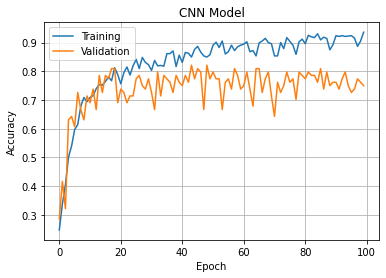

In [26]:
# plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model')
plt.savefig('cnn_accuracy_si.svg')

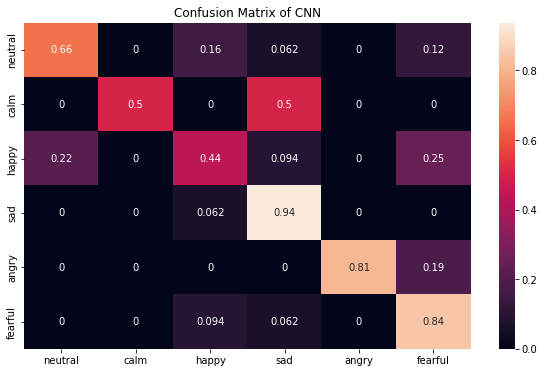

In [27]:
# make prediction for confusion_matrix
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(x_test, batch_size=16)
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']

# predicted emotions from the test set
y_pred = np.argmax(predict, 1)
predicted_emo = []
for i in range(0,y_test.shape[0]):
    emo = emotions[y_pred[i]]
    predicted_emo.append(emo)

# get actual emotion
actual_emo = []
y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = emotions[y_true[i]]
    actual_emo.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_emo, predicted_emo)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix of CNN')
sns.heatmap(cm_df, annot=True)
plt.savefig('cnn_cm_si.svg')

In [28]:
# print unweighted average recall
print("UAR: ", cm.trace()/cm.shape[0])

UAR:  0.6979166666666666
